In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.tools import tool
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition,InjectedState
from langchain_core.messages import (
    HumanMessage,
    ToolMessage,
)


from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import PromptTemplate
from langchain.output_parsers import RetryOutputParser
from langgraph.types import Command
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.tools.base import InjectedToolCallId
from langgraph.store.memory import InMemoryStore
from pydantic import BaseModel, Field
from typing_extensions import TypedDict
from typing import Annotated, Optional
#get graph visuals
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod
import os
from dotenv import load_dotenv 

import os.path
from google.oauth2.credentials import Credentials
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
load_dotenv()
GOOGLE_API_KEY=os.getenv('google_api_key')

In [2]:
GEMINI_MODEL='gemini-2.0-flash'
llm = ChatGoogleGenerativeAI(google_api_key=GOOGLE_API_KEY, model=GEMINI_MODEL, temperature=0.3)

In [3]:
class State(TypedDict):
    """
    A dictionnary representing the state of the agent.
    """
    query: str
    node_message: str
    tasklists:dict
    tasklist:dict

In [4]:
store=InMemoryStore()

In [5]:
if os.path.exists("token.json"):
    creds = Credentials.from_authorized_user_file("token.json")
try:
    # create gmail api client
    service = build("tasks", "v1", credentials=creds)

except HttpError as error:
    print(f"An error occurred: {error}")

In [6]:

def agent_node(state:State):
    class Route(BaseModel):
        route: str = Field(description="the route for the next node, either, create_task, list_tasks_from_specific_tasklist, list_tasks, get_task_details, show_tasklists, complete_task or END")

    parser=JsonOutputParser(pydantic_object=Route)
    prompt = PromptTemplate(
    template="Answer the user query.\n{format_instructions}\n{query}\n",
    input_variables=["query"],
    partial_variables={"format_instructions": parser.get_format_instructions()},
        )

        
    chain = prompt | llm 

    response=chain.invoke({'query':f'choose the route based on this query: {state.get('query')}'}) 
    try:
        response=parser.parse(response.content)
        return {'route':response.get('route')}
    except:
        
        retry_parser = RetryOutputParser.from_llm(parser=parser, llm=llm)

        prompt_value = prompt.format_prompt(query=state['query'])
        response=retry_parser.parse_with_prompt(response.content, prompt_value)
        return {'route':response.get('route')}

In [7]:
def router(state: State):
    route = state.get('route')
    
    routing_map = {
        'create_task': 'to_create_task',
        'list_tasks_from_specific_tasklist': 'to_list_tasks_from_specific_tasklist',
        'list_tasks': 'to_list_all_tasks',
        'get_task_details': 'to_get_task_details',
        'show_tasklists': 'to_show_tasklists',
        'complete_task': 'to_complete_task',
        'END': 'to_end'
    }
    
    return routing_map.get(route)

In [8]:
def show_tasklists_node(state:State):
    return {'node_message':state.get('tasklists')}

In [9]:
def get_tasklists_node(state: State):
    """Tool to get the tasklists, can be used to refresh tasklists
    agrs: none
    """
    try:
        tasklists=service.tasklists().list(maxResults=10).execute()
        tasklists={tasklist.get('title'):tasklist for tasklist in tasklists.get('items')}
       
        return {'tasklists':tasklists}
    except:  
        return {'node_message':'failed to get tasklists'}

In [10]:
def list_tasks_from_specific_tasklist_node(state:State):
    class Tasks(BaseModel):
        tasklist_id: str = Field(description="the id of the tasklist")
        
    parser=JsonOutputParser(pydantic_object=Tasks)
    prompt = PromptTemplate(
    template="Answer the user query.\n{format_instructions}\n{query}\n",
    input_variables=["query"],
    partial_variables={"format_instructions": parser.get_format_instructions()},
    )
    chain = prompt | llm 

    response=chain.invoke({'query':f'based on this query: {state.get('query')}, return the tasklist id from this list: {state.get('tasklists')}, for the tasklist specified in the query'}) 
    try:
        response=parser.parse(response.content)
        
    except:
        
        retry_parser = RetryOutputParser.from_llm(parser=parser, llm=llm)

        prompt_value = prompt.format_prompt(query=state['query'])
        response=retry_parser.parse_with_prompt(response.content, prompt_value)

    
    tasklist=service.tasks().list(tasklist=response.get('tasklist_id')).execute()
    tasks={task.get('title'):task for task in tasklist.get('items')}
    tasks={'id':response.get('tasklist_id'),
           'tasks':tasks}
    return {'tasklist':tasks,
                'node_message':tasks}

In [11]:
def get_tasks_node(state:State):
    try:
        tasklists=state.get('tasklists')
        tasklist=service.tasks().list(tasklist=tasklists['My Tasks']['id']).execute()
        tasks={task.get('title'):task for task in tasklist.get('items')}
        tasks={'id':tasklists['My Tasks']['id'],
           'tasks':tasks}
        return {'tasklist':tasks}
    except: 
        return {'node_message':'failed to get tasklist'}

In [12]:
def list_tasks_node(state: State):

    
    try:
        tasks=state.get('tasklist')
        
        return {
                    'node_message':tasks}
    except: 
        return {'node_message':'failed to get tasklist'}

In [13]:
def get_task_details_node(state: State):
    """Tool to get a task detail, can be used to refresh tasks
    args: task_id - the id of the task
    """
    class Task(BaseModel):
        task_id: str = Field(description="the id of the task")
            
    parser=JsonOutputParser(pydantic_object=Task)
    prompt = PromptTemplate(
    template="Answer the user query.\n{format_instructions}\n{query}\n",
    input_variables=["query"],
    partial_variables={"format_instructions": parser.get_format_instructions()},
    )
    chain = prompt | llm 
    
    response=chain.invoke({'query':f'based on this query: {state.get('query')}, return the id of the task specified in the query from this list of tasks: {state.get('tasklist')}'}) 
    try:
        response=parser.parse(response.content)
        
    except:
        
        retry_parser = RetryOutputParser.from_llm(parser=parser, llm=llm)

        prompt_value = prompt.format_prompt(query=state['query'])
        response=retry_parser.parse_with_prompt(response.content, prompt_value)

    tasklist_id=state['tasklist'].get('id')
    task=service.tasks().get(tasklist=tasklist_id, task=response.get('task_id')).execute()
    return {'node_message':task}
   

In [14]:
def complete_task_node(state:State):
    """tool to complete a task, once a task is completed it is deleted
    args: task_id - the id of the task, can be found using list_tasks tool
    """

    class Task(BaseModel):
        task_id: str = Field(description="the id of the task")
            
    parser=JsonOutputParser(pydantic_object=Task)
    prompt = PromptTemplate(
    template="Answer the user query.\n{format_instructions}\n{query}\n",
    input_variables=["query"],
    partial_variables={"format_instructions": parser.get_format_instructions()},
    )
    chain = prompt | llm 
    
    response=chain.invoke({'query':f'based on this query: {state.get('query')}, return the id of the task specified in the query from this list of tasks: {state.get('tasklist')}'}) 
    try:
        response=parser.parse(response.content)
        
    except:
        
        retry_parser = RetryOutputParser.from_llm(parser=parser, llm=llm)

        prompt_value = prompt.format_prompt(query=state['query'])
        response=retry_parser.parse_with_prompt(response.content, prompt_value)
        
    try:
        tasklist_id=state['tasklist'].get('id')
        task=service.tasks().get(tasklist=tasklist_id, task=response.get('task_id')).execute()
        task['status']='completed'
        response=service.tasks().update(tasklist=tasklist_id,task=response.get('task_id'), body=task).execute()
        clear=service.tasks().clear(tasklist=tasklist_id).execute()
        return {'node_message': 'Task Completed'}
    except:
        return {'node_message':' couldnt complete task'}

In [ ]:

def create_task_node(state: State):


    class task_shema(BaseModel):
      title: str = Field(description="Title of the task. Maximum length allowed: 1024 characters")
      notes: str = Field(description="Notes describing the task. Maximum length allowed: 8192 characters.Optional.")
      due: Optional[str] = Field(description="Due date of the task (as a RFC 3339 timestamp)}. Optional. The due date only records date information; the time portion of the timestamp is discarded when setting the due date.")
            
    parser=JsonOutputParser(pydantic_object=task_shema)
    prompt = PromptTemplate(
    template="Answer the user query.\n{format_instructions}\n{query}\n",
    input_variables=["query"],
    partial_variables={"format_instructions": parser.get_format_instructions()},
    )
    chain = prompt | llm 
    
    response=chain.invoke({'query':f'based on this query: {state.get('query')}, create the task specified in the query'}) 
    try:
        response=parser.parse(response.content)
        
    except:
        
        retry_parser = RetryOutputParser.from_llm(parser=parser, llm=llm)

        prompt_value = prompt.format_prompt(query=state['query'])
        response=retry_parser.parse_with_prompt(response.content, prompt_value)

    tasklist_id=state['tasklist'].get('id')
    try:
      task=service.tasks().insert(tasklist=tasklist_id,body=response).execute()
      return {'node_message':'task created'}

    except:
      return {'node_message': 'failed to create task'}
        


In [16]:
class tasks_agent:
    def __init__(self,llm : any):
        self.agent=self._setup(llm)
    def _setup(self,llm):
       
        graph_builder = StateGraph(State)

        graph_builder.add_node("agent", agent_node)

        graph_builder.add_node("create_task", create_task_node)
        graph_builder.add_node('get_tasklists', get_tasklists_node)
        graph_builder.add_node('list_tasks',list_tasks_node)
        graph_builder.add_node("list_tasks_from_specific_tasklist",list_tasks_from_specific_tasklist_node)
        graph_builder.add_node('complete_task',complete_task_node)
        graph_builder.add_node('show_tasklists',show_tasklists_node)
        graph_builder.add_node('get_task_details',get_task_details_node)
        graph_builder.add_node('get_tasks', get_tasks_node)
        
        graph_builder.set_entry_point("get_tasklists")
        graph_builder.add_edge("get_tasklists", "get_tasks")
        graph_builder.add_edge("get_tasks", 'agent')
        graph_builder.add_conditional_edges(
            "agent",
            router,{
                'to_create_task': 'create_task',
                'to_list_tasks_from_specific_tasklist': 'list_tasks_from_specific_tasklist',
                'to_list_all_tasks': 'list_tasks',
                'to_get_task_details': 'get_task_details',
                'to_show_tasklists': 'show_tasklists',
                'to_complete_task': 'complete_task',
                'to_end': END
            }
        )
        graph_builder.add_edge('create_task',END)
        graph_builder.add_edge('show_tasklists',END)
        graph_builder.add_edge('complete_task',END)
        graph_builder.add_edge('get_task_details',END)
        graph_builder.add_edge('list_tasks',END)
        graph_builder.add_edge('list_tasks_from_specific_tasklist',END)
        memory=MemorySaver()
        graph=graph_builder.compile(checkpointer=memory, store=store)
        return graph
        

    def display_graph(self):
        return display(
                        Image(
                                self.agent.get_graph().draw_mermaid_png(
                                    draw_method=MermaidDrawMethod.API,
                                )
                            )
                        )
    def chat(self,input:str):
        config = {"configurable": {"thread_id": "1"}}
        response=self.agent.invoke({'query':input,
                                    'num_retries':0},config)
        return response

    def stream(self,input:str):
        config = {"configurable": {"thread_id": "1"}}
        for event in self.agent.stream({'query':input,
                                        'num_retries':0}, config, stream_mode="updates"):
            print(event)
    
    def get_state(self, state_val:str):
        config = {"configurable": {"thread_id": "1"}}
        return self.agent.get_state(config).values[state_val]

In [17]:
agent=tasks_agent(llm)

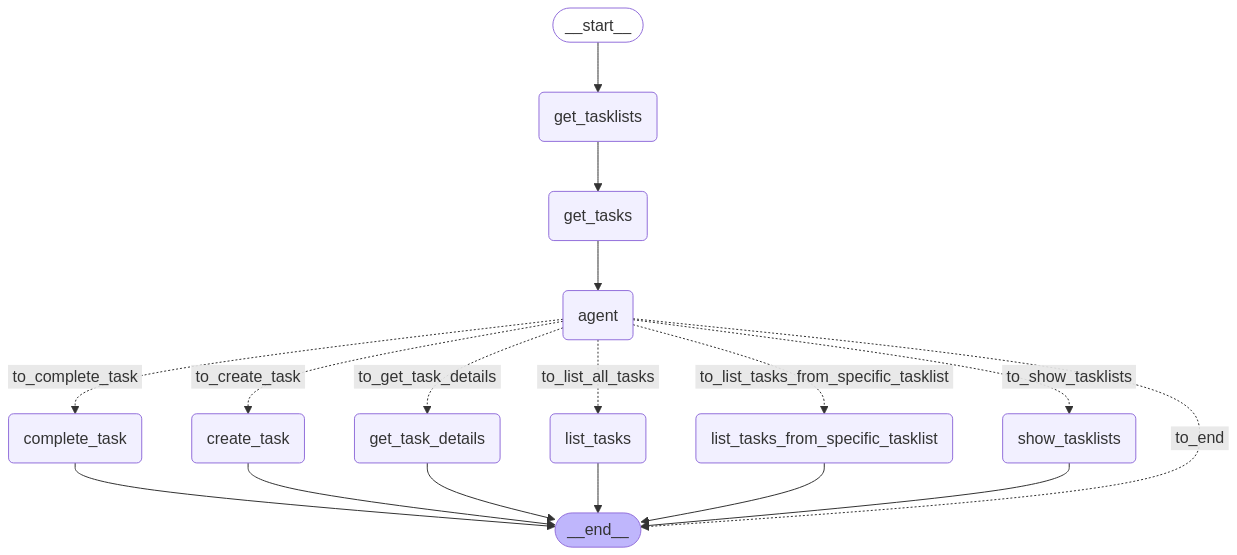

In [18]:
agent.display_graph()

In [19]:
agent.stream('create task named Take fina for 8:00 am')

{'get_tasklists': {'tasklists': {'My Tasks': {'kind': 'tasks#taskList', 'id': 'MDMyNDkzMjIzMzQ5ODI4MTU2MjY6MDow', 'etag': '"LTE5NTQ0OTM5ODI"', 'title': 'My Tasks', 'updated': '2025-03-12T17:57:07.798Z', 'selfLink': 'https://www.googleapis.com/tasks/v1/users/@me/lists/MDMyNDkzMjIzMzQ5ODI4MTU2MjY6MDow'}}}}
{'get_tasks': {'tasklist': {'id': 'MDMyNDkzMjIzMzQ5ODI4MTU2MjY6MDow', 'tasks': {}}}}
{'agent': None}
{'create_task': {'node_message': 'task created'}}
